<a href="https://colab.research.google.com/github/Gkavin6668/projects/blob/main/UNET_TRY1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

from keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
epochs = 100
height = 256
width = 256

img_chan = 3
img_cls = 5

ipath = '/content/drive/MyDrive/dataset/ng/train/images'
mpath = '/content/drive/MyDrive/dataset/ng/train/masks'

tipath = '/content/drive/MyDrive/dataset/ng/test/images'
tmpath = '/content/drive/MyDrive/dataset/ng/test/masks'



In [4]:
images = sorted(os.listdir(ipath))
masks = sorted(os.listdir(mpath))

timages = sorted(os.listdir(tipath))
tmasks = sorted(os.listdir(tmpath))

print(len(images))
print(len(masks))

1002
1002


In [5]:
colors = [
    [0, 0, 0],
    [0, 255, 255],
    [255, 0, 0],
    [153, 76, 0],
    [0, 153, 0]
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [6]:
train_images = []
train_masks = []

test_images = []
test_masks = []

In [7]:
for image_filename, mask_filename in tqdm(zip(images, masks),total = len(images)):
    image_path = os.path.join(ipath, image_filename)
    mask_path = os.path.join(mpath, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (height, width))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (height, width))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,colors)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [02:29<00:00,  6.69it/s]


In [8]:
for image_filename, mask_filename in tqdm(zip(timages, tmasks),total = len(timages)):
    image_path = os.path.join(tipath, image_filename)
    mask_path = os.path.join(tmpath, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (height, width))

    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (height, width))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,colors)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

 44%|████▎     | 48/110 [01:05<01:24,  1.37s/it]


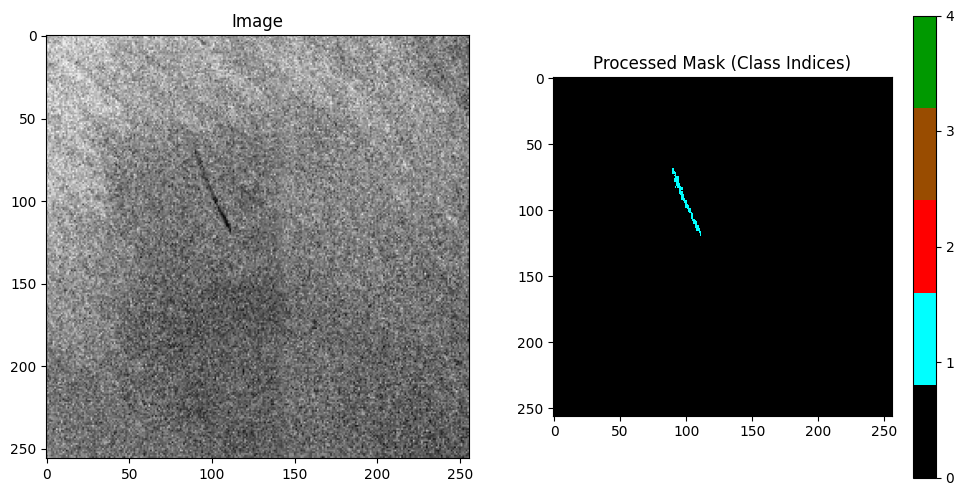

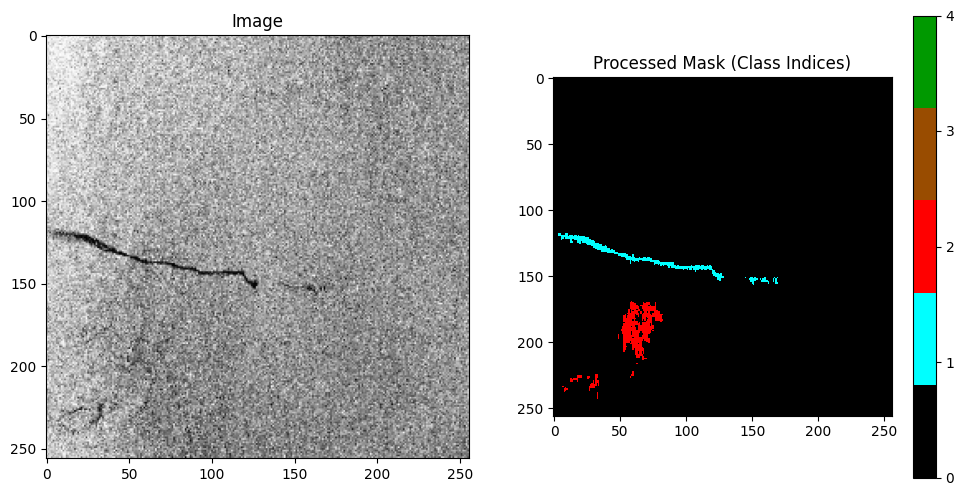

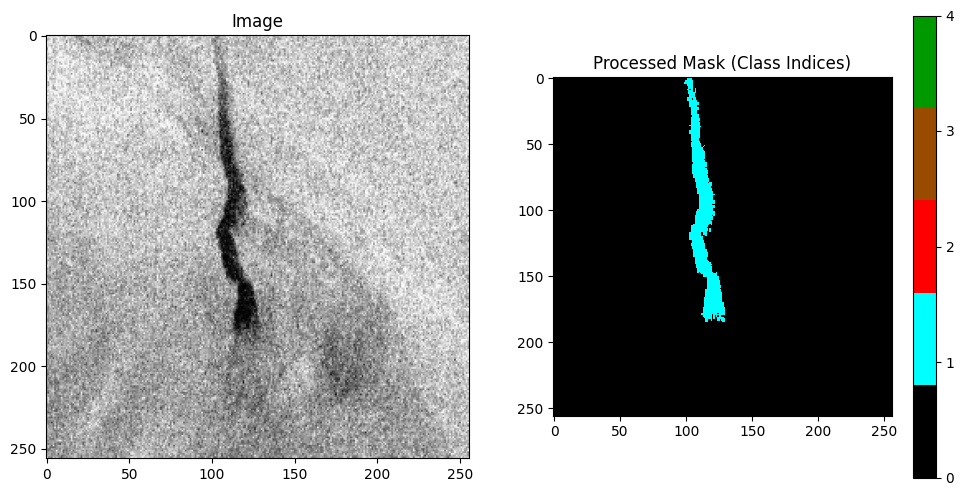

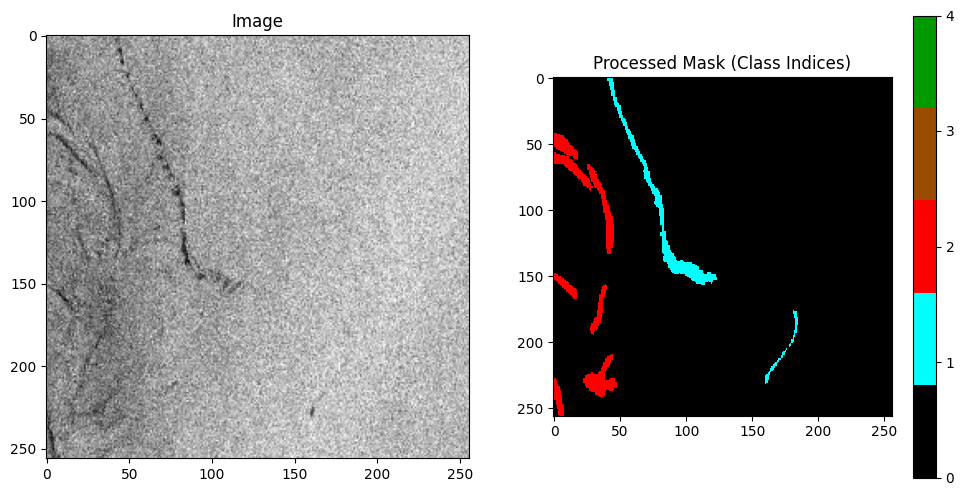

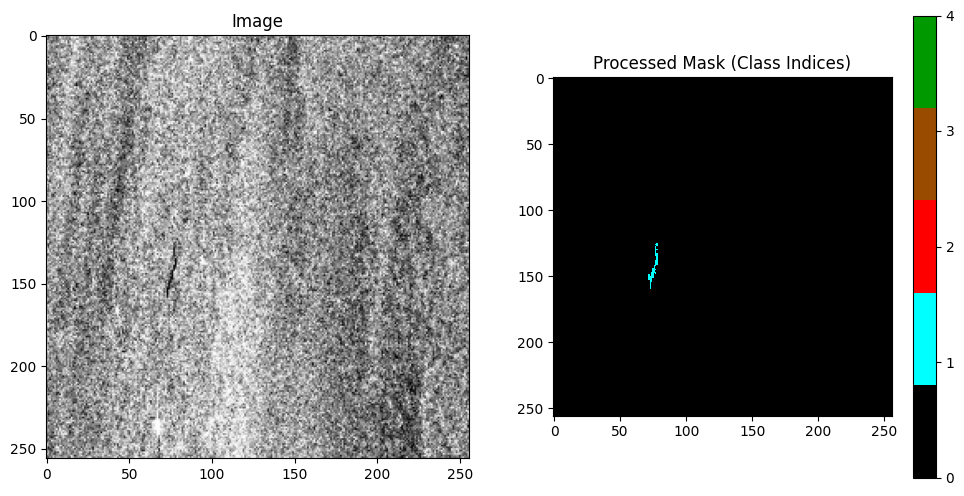

In [9]:
import matplotlib.colors as mcolors

# Scale the color values in colors to the range [0, 1]
scaled_colors = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in colors]

# Define a consistent color map based on the scaled colors
cmap = mcolors.ListedColormap(scaled_colors)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(colors) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(colors)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

In [10]:
train_masks = to_categorical(train_masks, num_classes = 5)

In [11]:
input_shape = (height, width, img_chan)

In [12]:
def encoder_block(inputs, num_filters):
    x = Conv2D(num_filters, (3,3),activation="relu",kernel_initializer="he_normal", padding="same")(inputs)
    x = Dropout(0.1)(x)
    x = Conv2D(num_filters, (3,3),activation="relu",kernel_initializer="he_normal", padding="same")(x)
    p = MaxPool2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    u = Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding="same")(inputs)
    u = concatenate([u, skip])
    x = Conv2D(num_filters, (3,3),activation="relu",kernel_initializer="he_normal", padding="same")(u)
    x = Dropout(0.1)(x)
    x = Conv2D(num_filters, (3,3),activation="relu",kernel_initializer="he_normal", padding="same")(x)
    return x


def build_unet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    c6 = decoder_block(c5, c4, 128)
    c7 = decoder_block(c6, c3, 64)
    c8 = decoder_block(c7, c2, 32)
    c9 = decoder_block(c8, c1, 16)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model


In [13]:
model = build_unet(input_shape,img_cls)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,173 (7.40 MB)

 Trainable params: 1,941,173 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [16]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [17]:
unet_history = model.fit(
    train_images,
    train_masks,
    epochs = epochs,
    batch_size=8,
    verbose = 1,
    validation_split=0.1,
    callbacks=callbacks

)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 274ms/step - accuracy: 0.7613 - loss: 0.8150 - val_accuracy: 0.8967 - val_loss: 0.3853 - learning_rate: 0.0010
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.8820 - loss: 0.4247 - val_accuracy: 0.9181 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8861 - loss: 0.3704 - val_accuracy: 0.9182 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8837 - loss: 0.3661 - val_accuracy: 0.9088 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.8881 - loss: 0.3315 - val_accuracy: 0.9258 - val_loss: 0.2207 - learning_rate: 0.0010
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9038 - loss: 0.2835 - val_accuracy: 0.9204 - val_loss: 0.2285 - learning_rate: 0.0010
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.91

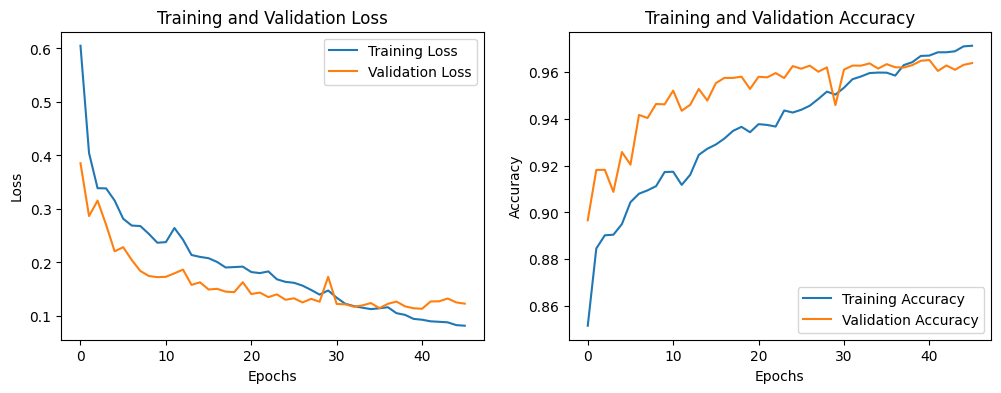

In [18]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']
unet_accuracy = unet_history.history['accuracy']
unet_val_accuracy = unet_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


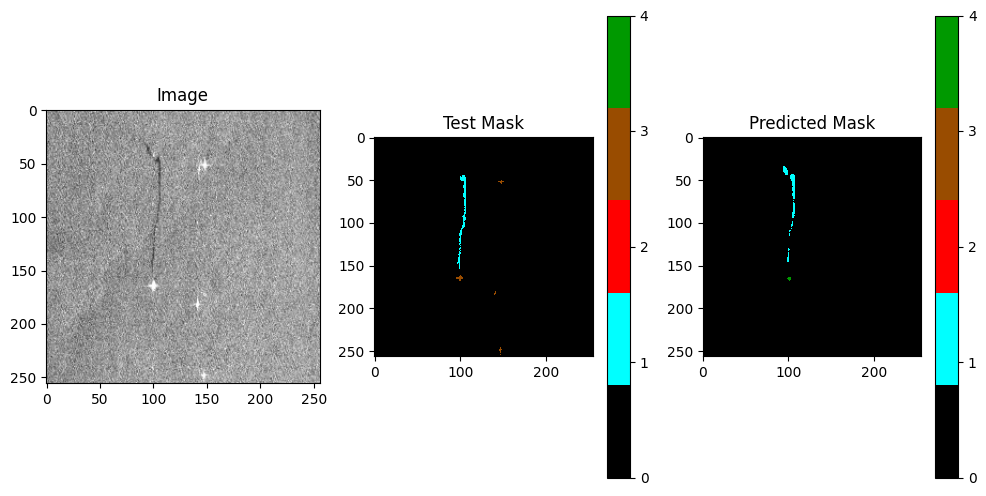

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


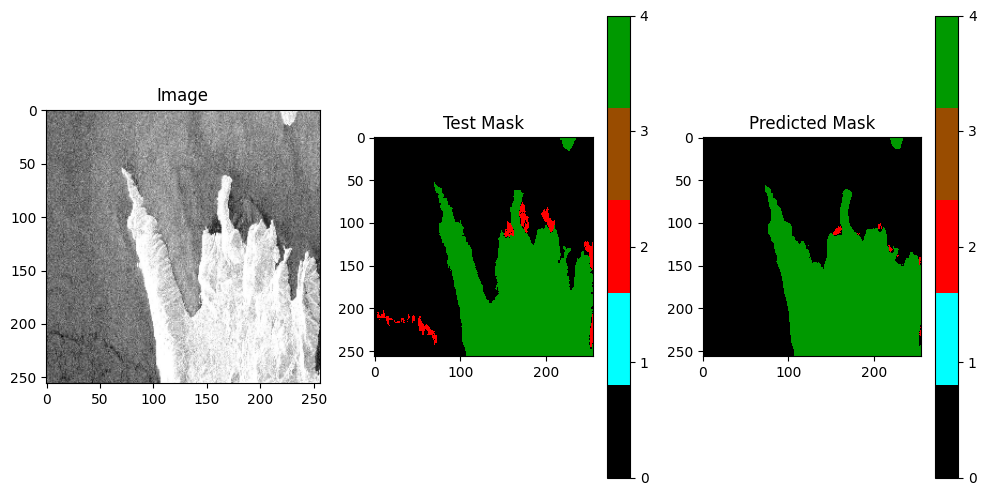

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


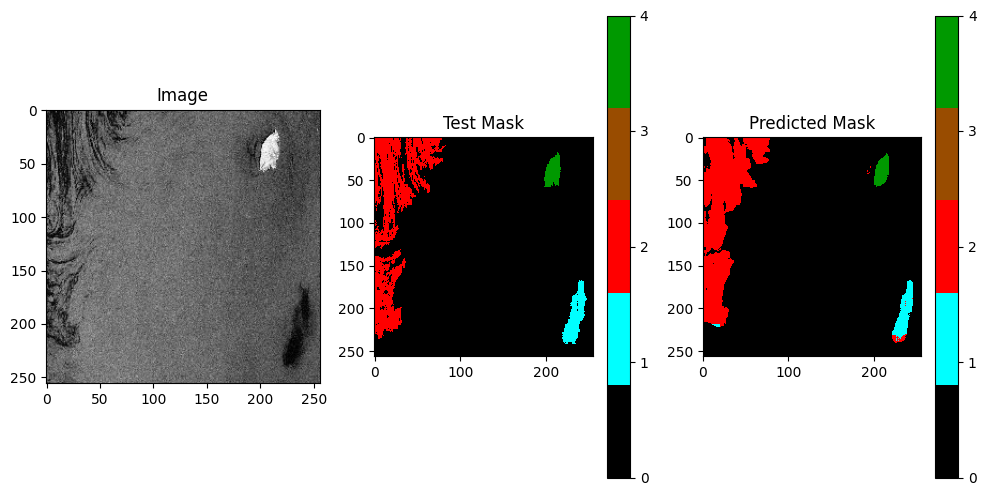

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


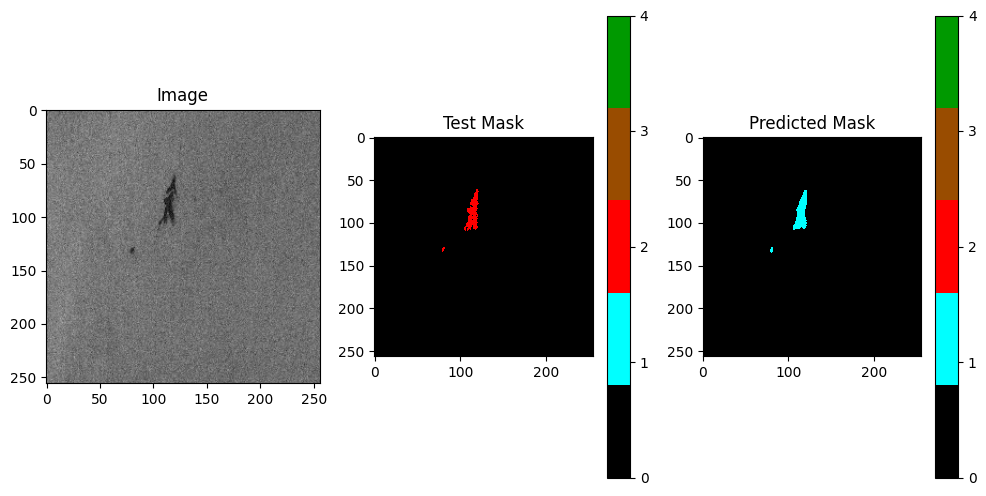

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


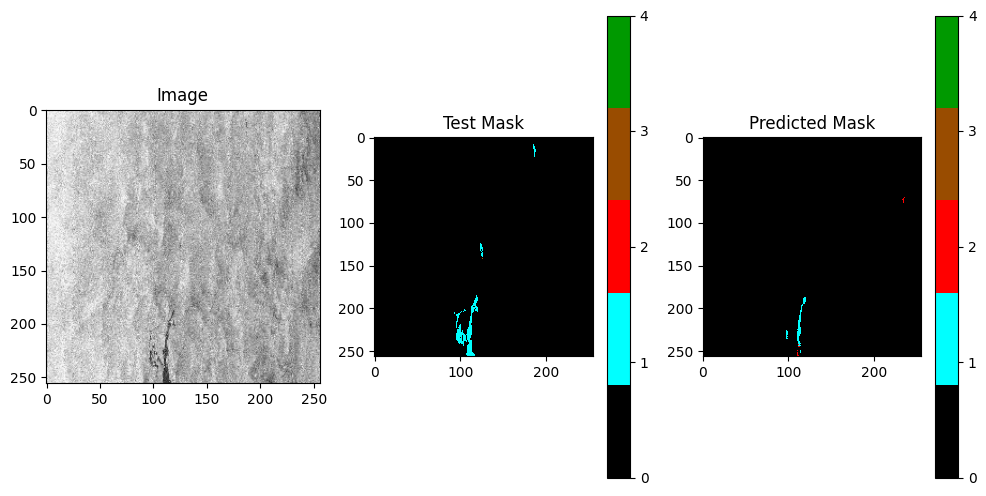

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


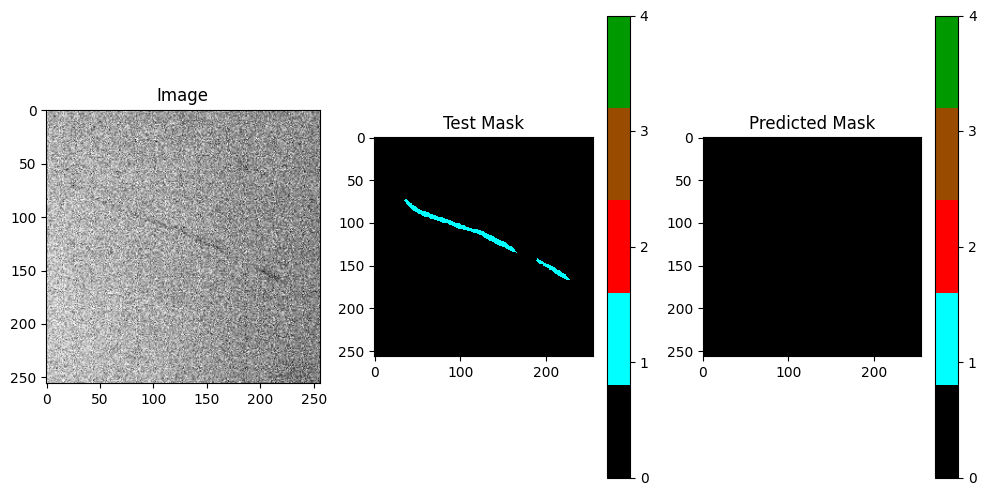

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


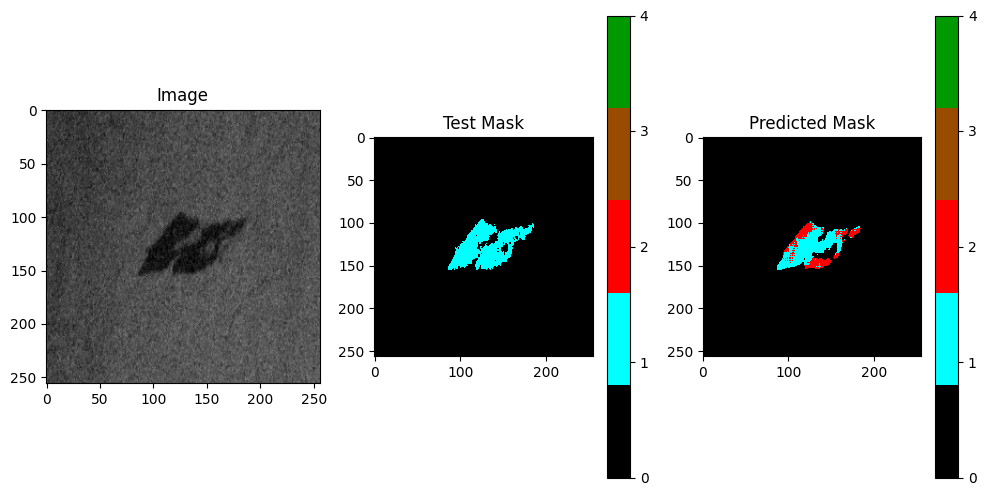

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


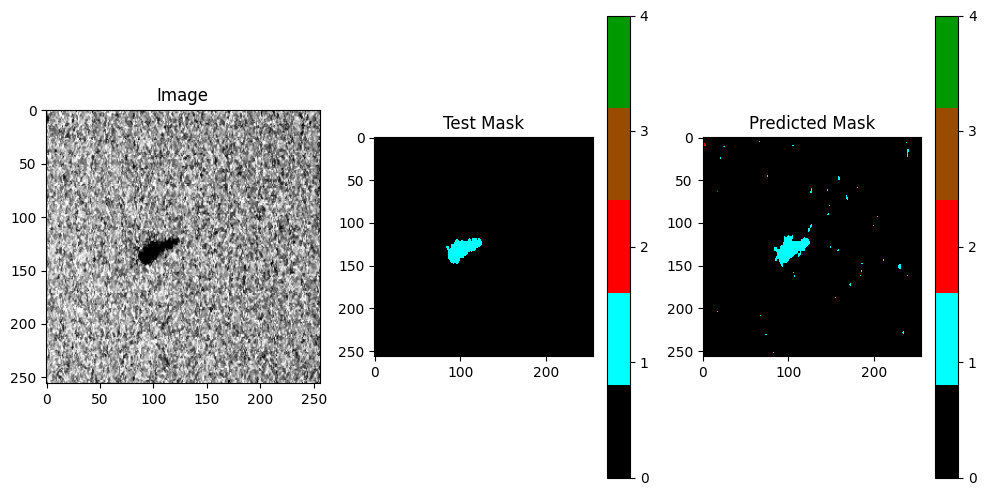

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


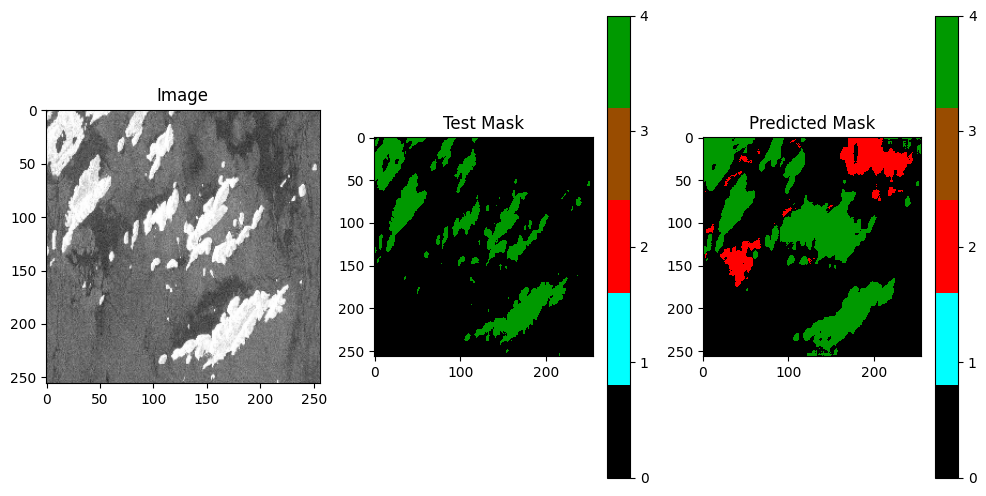

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


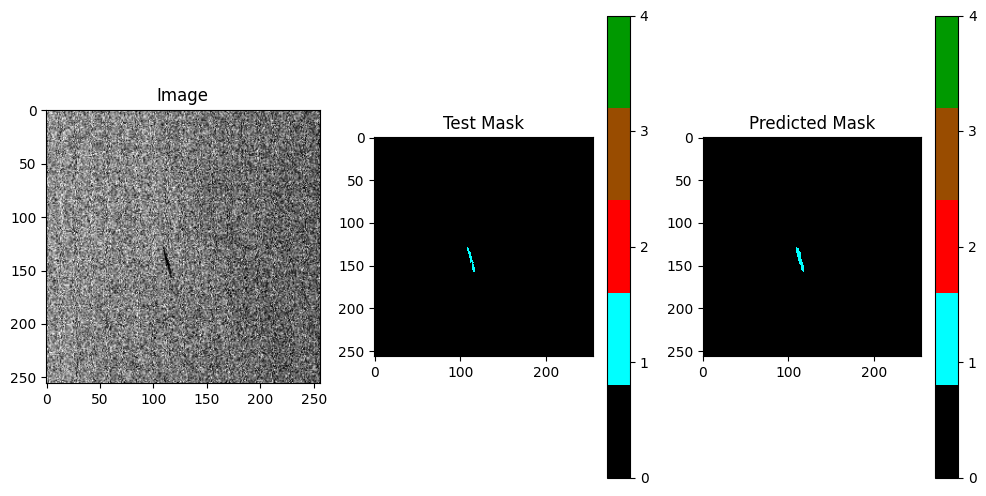

In [19]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

    # Test Image
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")

    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(colors) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(colors)))
    plt.title("Test Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(colors) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(colors)))
    plt.title("Predicted Mask")

    plt.show()

In [20]:
model.save('/content/drive/MyDrive/files/tries/try1.h5')